In [1]:
import pandas as pd
import os
from matplotlib import pylab as plt
import numpy as np
from pyteomics import mzml, fasta, parser
from matplotlib_venn import venn2, venn3
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches

In [2]:
# plt.rcParams['font.size'] = 8
dot_size = 10
font_on_figure = 8
plt.rcParams.update({'mathtext.default':  'regular' })

In [3]:
# define an object that will be used by the legend
class MulticolorPatch(object):
    def __init__(self, colors):
        self.colors = colors
        
# define a handler for the MulticolorPatch object
class MulticolorPatchHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        width, height = handlebox.width, handlebox.height
        patches = []
        for i, c in enumerate(orig_handle.colors):
            patches.append(plt.Rectangle([width/len(orig_handle.colors) * i - handlebox.xdescent, 
                                          -handlebox.ydescent],
                           width / len(orig_handle.colors),
                           height, 
                           facecolor=c, 
                           edgecolor='black'))

        patch = PatchCollection(patches, match_original=True)

        handlebox.add_artist(patch)
        return patch

## Functions

In [4]:
def get_spectronaut_res(work_dir, inj=None, analysis=None, method=None, sample=None):
    out = []
    for f in os.listdir(work_dir):
        data = {}
        df = pd.read_table(os.path.join(work_dir, f), low_memory=False)
        df.index = df["Parameter"]
        df = df["Value"].to_dict()
        data["file"] = f.split(".")[0]
        data["LC, min"] = float(df["Gradient Length [min]"])
        data["Median FWHM, s"] = round(float(df["Median FWHM"].split(' ')[0])*60, 2)
        data["Data Points per Peak (MS1)"] = float(df["Data Points per Peak (MS1)"].split(' ')[0])
        data["Data Points per Peak (MS2)"] = float(df["Data Points per Peak (MS2)"].split(' ')[0])
        data["Precursors"] =  0 if df["Precursors"].split(" of")[0].replace("\xa0", "")=="NA" else int(df["Precursors"].split(" of")[0].replace("\xa0", ""))
        data["Precursors_all"] = int(df["Precursors"].split(" ")[2].replace("\xa0",""))
        data["PG"] = 0 if df['Protein Groups'].split(" of")[0].replace("\xa0", "")=="NA" else int(df['Protein Groups'].split(" of")[0].replace("\xa0", "")) 
        data["PG_all"] = int(df['Protein Groups'].split(" of")[1].replace("\xa0", ""))
        data["Sample"] = sample
        data["injection"] = inj
        data["analysis"] = analysis
        data["method"] = method
        data["experiment"] = work_dir.split("/")[-3]
        data["path"] = df['Raw File Name']
        out.append(pd.Series(data))
    return  pd.concat(out, axis=1).T

In [5]:
def add_cvs(work_dir):
    """Return CV for MS1 intensities peptide, prot lvl and MS2 int at peptide and prot lvl""" 
    df = pd.DataFrame({})
    pep_file = [x for x in os.listdir(work_dir) if ("Peptides_JB" in x) and x.endswith(".tsv")]
    df_pep = pd.read_table(os.path.join(work_dir, pep_file[0]), low_memory=False)
    df_pep.replace("Filtered", np.nan, inplace=True)
    cols_pep_ms1 = [x for x in df_pep.columns if "PEP.MS1Quantity" in x]
    cols_pep_ms2 = [x for x in df_pep.columns if "PEP.MS2Quantity" in x]
    df_slice = df_pep.loc[:, cols_pep_ms1 + cols_pep_ms2].dropna()
    cv_pep_ms1  = df_slice.loc[:, cols_pep_ms1].astype(float).std(axis=1) / df_slice.loc[:, cols_pep_ms1].astype(float).mean(axis=1) * 100
    cv_pep_ms2  = df_slice.loc[:, cols_pep_ms2].astype(float).std(axis=1) / df_slice.loc[:, cols_pep_ms2].astype(float).mean(axis=1) * 100
    cv_pep_ms1 = cv_pep_ms1.dropna().median()
    cv_pep_ms2 = cv_pep_ms2.dropna().median()
    
    prot_file = [x for x in os.listdir(work_dir) if ("Protein_JB" in x) and x.endswith(".tsv")]
    df_prot = pd.read_table(os.path.join(work_dir, prot_file[0]), low_memory=False)    
    df_prot["id"] = df_prot["PG.ProteinGroups"].apply(lambda x: x.split(";")[0])
    cols_prot_ms1 = [x for x in df_prot.columns if ".MS1Quantity" in x]
    cols_prot_ms2 = [x for x in df_prot.columns if ".MS2Quantity" in x]
    cv_prot_ms1  = df_prot.loc[:, cols_prot_ms1].std(axis=1) / df_prot.loc[:, cols_prot_ms1].mean(axis=1) * 100
    cv_prot_ms2  = df_prot.loc[:, cols_prot_ms2].std(axis=1) / df_prot.loc[:, cols_prot_ms2].mean(axis=1) * 100
    cv_prot_ms1 = cv_prot_ms1.dropna().median()
    cv_prot_ms2 = cv_prot_ms2.dropna().median()
    return cv_pep_ms1, cv_prot_ms1, cv_pep_ms2 , cv_prot_ms2

In [6]:
def get_experiment_statistics(df):
    experiment = {}
    experiment["experiment"] = "_".join(df.experiment[0].split("_")[2:])
    experiment["LC"] = df["LC, min"][0]
    experiment["Sample"] = df.Sample[0]
    experiment["injection"] = df.injection[0]
    experiment["analysis"] = df.analysis[0]
    experiment["method"] = df.method[0]
    experiment["PG_mean"] = df.PG.mean()
    experiment["PG_std"] = df.PG.std()
    experiment["PG"] = [list(df.PG)]
    experiment["PG_all"] = df.PG_all[0]
    experiment["DPPP_MS1"] = df["Data Points per Peak (MS1)"][0]
    experiment["DPPP_MS2"] = df["Data Points per Peak (MS2)"][0]
    experiment["Precursors_mean"] = df.Precursors.mean()
    experiment["Precursors_std"] = df.Precursors.std()
    experiment["Precursors"] = [list(df.Precursors)]
    experiment["Precursors_all"] = df.Precursors_all[0]
    experiment["FWHM, s"] = df["Median FWHM, s"].mean()
    experiment["folder"] = df.experiment[0]
    experiment["name"] = "\n".join(["_".join([df.Sample[0], df.injection[0]]), df.method[0], df.analysis[0]])  
    experiment["short_name"] =  "_".join([df.injection[0], df.analysis[0]])
    return pd.DataFrame(experiment)

In [7]:
def get_param_table(data, x_param, y_param, inj="any"):
    x_ticks = sorted(data[x_param].unique())
    df = pd.DataFrame(index=x_ticks, columns=data.analysis.unique())
    df = df.apply(lambda x: [])
    data.index = data[x_param]
    if inj == "any":
        for c in data.analysis.unique():
            df[c] = data[(data.analysis == c)][y_param]
    else:
        for c in data.analysis.unique():
            df[c] = data[(data.analysis == c) & (data.injection == inj)][y_param]
    return df

In [8]:
def get_FP(work_dir):
    pep_file = [x for x in os.listdir(work_dir) if ("Peptides_JB" in x) and x.endswith(".tsv")]
    df_pep = pd.read_table(os.path.join(work_dir, pep_file[0]), low_memory=False)
    cols_pep = [x for x in df_pep.columns if "PEP.MS1Quantity" in x]
    pep_fake = list(df_pep[df_pep["PG.ProteinGroups"].apply(lambda x: "JB_FAKE" in x)].loc[:,cols_pep].count())
    sum_pep_fake = df_pep[df_pep["PG.ProteinGroups"].apply(lambda x: "JB_FAKE" in x)].shape[0]
    prot_file = [x for x in os.listdir(work_dir) if ("Protein_JB" in x) and x.endswith(".tsv")]
    df_prot = pd.read_table(os.path.join(work_dir, prot_file[0]), low_memory=False)    
    cols= [x for x in df_prot.columns if "PG.Quantity" in x]
    prot_fake = list(df_prot[df_prot["PG.ProteinGroups"].apply(lambda x: "JB_FAKE" in x)].loc[:,cols].count())
    sum_prot_fake = df_prot[df_prot["PG.ProteinGroups"].apply(lambda x: "JB_FAKE" in x)].shape[0]
    return prot_fake, pep_fake, sum_prot_fake, sum_pep_fake, df_prot.shape[0], len(set(df_pep["EG.PrecursorId"]))

In [9]:
def get_FP_celegants(work_dir):
    pep_file = [x for x in os.listdir(work_dir) if ("Peptides_JB" in x) and x.endswith(".tsv")]
    df_pep = pd.read_table(os.path.join(work_dir, pep_file[0]), low_memory=False)
    cols_pep = [x for x in df_pep.columns if "PEP.MS1Quantity" in x]
    df_pep["pep_fake"] = df_pep["PG.ProteinGroups"].apply(lambda x: x.split(";")[0] in protid_CElegans)
    pep_fake = list(df_pep[df_pep["pep_fake"] == True].loc[:,cols_pep].count())
    sum_pep_fake = df_pep[df_pep["pep_fake"] == True].shape[0]
    prot_file = [x for x in os.listdir(work_dir) if ("Protein_JB" in x) and x.endswith(".tsv")]
    df_prot = pd.read_table(os.path.join(work_dir, prot_file[0]), low_memory=False)    
    cols = [x for x in df_prot.columns if "PG.Quantity" in x]
    df_prot["prot_fake"] = df_prot["PG.ProteinGroups"].apply(lambda x: x.split(";")[0] in protid_CElegans)
    prot_fake = list(df_prot[df_prot["prot_fake"] == True].loc[:,cols].count())
    sum_prot_fake = df_prot[df_prot["prot_fake"]==True].shape[0]
    return prot_fake, pep_fake, sum_prot_fake, sum_pep_fake, df_prot.shape[0], len(set(df_pep["EG.PrecursorId"]))

In [10]:
def get_experiment_statistics_fdr(df):
    experiment = {}
    experiment["experiment"] = df.experiment[0][16:]
    experiment["LC"] = float(df["LC, min"][0])
    experiment["Sample"] = df.Sample[0]
    experiment["injection"] = df.injection[0]
    experiment["analysis"] = df.analysis[0]
    experiment["method"] = df.method[0]
    experiment["PG_mean"] = df.PG.mean()
    experiment["PG_std"] = df.PG.std()
    experiment["Precursors_mean"] = df.Precursors.mean()
    experiment["Precursors_std"] = df.Precursors.std()
    experiment["name"] = "\n".join(["_".join([df.Sample[0], df.injection[0]]), df.method[0], df.analysis[0]])  
    experiment["PG_fake_mean"] = df["prot_fake"].mean()
    experiment["PG_fake_std"] = df["prot_fake"].std()
    experiment["sum_PG_fake"] = df["sum_prot_fake"].mean()
    experiment["Precursor_fake_mean"] = df["Precursor_fake"].mean()
    experiment["Precursor_fake_std"] = df["Precursor_fake"].std()
    experiment["sum_Precursor_fake"] = df["sum_Precursor_fake"].mean()
    experiment["sum_Precursor"] = df["sum_Precursor"].mean()
    experiment["sum_PG"] = df["sum_prot"].mean()
    return pd.DataFrame(experiment, index=[1])

## Data loading

In [11]:
all_data = []

### HeLa

In [12]:
working_dir = "/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/HeLa_250pg_30-80SPD/20240209_104216_JB_HeLa250pg_240k_20Th_40ms_30SPD_MBR/"
df = get_spectronaut_res(os.path.join(working_dir, "RunSummaries/"), 
                         inj="250pg", 
                         analysis='MBR',
                         method="20Th_40ms_30SPD", 
                         sample="HeLa")
df_line = get_experiment_statistics(df)
cvs = add_cvs(working_dir)
df_line[["pep_ms1_cv", "prot_ms1_cv", "pep_ms2_cv", "prot_ms2_cv"] ] = cvs
all_data.append(df_line)

# [pep_ms1, prot_ms1, pep_ms2 ,prot_ms2
working_dir = "/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/HeLa_250pg_30-80SPD/20240209_103434_JB_HeLa250pg_240k_20Th_40ms_30SPD_noMBR/"
df = get_spectronaut_res(os.path.join(working_dir, "RunSummaries/"), 
                         inj="250pg", 
                         analysis='noMBR',
                         method="20Th_40ms_30SPD", 
                         sample="HeLa")
df_line = get_experiment_statistics(df)
cvs = add_cvs(working_dir)
df_line[["pep_ms1_cv", "prot_ms1_cv", "pep_ms2_cv", "prot_ms2_cv"] ] = cvs
all_data.append(df_line)

working_dir = "/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/HeLa_250pg_30-80SPD/20240209_104251_JB_HeLa250pg_240k_20Th_40ms_40SPD_MBR/"
df = get_spectronaut_res(os.path.join(working_dir, "RunSummaries/"), 
                         inj="250pg", 
                         analysis='MBR',
                         method="20Th_40ms_40SPD", 
                         sample="HeLa")
df_line = get_experiment_statistics(df)
cvs = add_cvs(working_dir)
df_line[["pep_ms1_cv", "prot_ms1_cv", "pep_ms2_cv", "prot_ms2_cv"] ] = cvs
all_data.append(df_line)

working_dir = "/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/HeLa_250pg_30-80SPD/20240209_103517_JB_HeLa250pg_240k_20Th_40ms_40SPD_noMBR/"
df = get_spectronaut_res(os.path.join(working_dir, "RunSummaries/"), 
                         inj="250pg", 
                         analysis='noMBR',
                         method="20Th_40ms_40SPD", 
                         sample="HeLa")
df_line = get_experiment_statistics(df)
cvs = add_cvs(working_dir)
df_line[["pep_ms1_cv", "prot_ms1_cv", "pep_ms2_cv", "prot_ms2_cv"] ] = cvs
all_data.append(df_line)

working_dir = "/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/HeLa_250pg_30-80SPD/20240209_103639_JB_HeLa250pg_240k_20Th_40ms_50SPD_noMBR/"
df = get_spectronaut_res(os.path.join(working_dir, "RunSummaries/"), 
                         inj="250pg", 
                         analysis='noMBR',
                         method="20Th_40ms_50SPD", 
                         sample="HeLa")
df_line = get_experiment_statistics(df)
cvs = add_cvs(working_dir)
df_line[["pep_ms1_cv", "prot_ms1_cv", "pep_ms2_cv", "prot_ms2_cv"] ] = cvs
all_data.append(df_line)

working_dir = "/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/HeLa_250pg_30-80SPD/20240209_104330_JB_HeLa250pg_240k_20Th_40ms_50SPD_MBR/"
df = get_spectronaut_res(os.path.join(working_dir, "RunSummaries/"), 
                         inj="250pg", 
                         analysis='MBR',
                         method="20Th_40ms_50SPD", 
                         sample="HeLa")
df_line = get_experiment_statistics(df)
cvs = add_cvs(working_dir)
df_line[["pep_ms1_cv", "prot_ms1_cv", "pep_ms2_cv", "prot_ms2_cv"] ] = cvs
all_data.append(df_line)

working_dir = "/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/HeLa_250pg_30-80SPD/20240209_104418_JB_HeLa250pg_240k_20Th_40ms_60SPD_MBR/"
df = get_spectronaut_res(os.path.join(working_dir, "RunSummaries/"), 
                         inj="250pg", 
                         analysis='MBR',
                         method="20Th_40ms_60SPD", 
                         sample="HeLa")
df_line = get_experiment_statistics(df)
cvs = add_cvs(working_dir)
df_line[["pep_ms1_cv", "prot_ms1_cv", "pep_ms2_cv", "prot_ms2_cv"] ] = cvs
all_data.append(df_line)

working_dir = "/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/HeLa_250pg_30-80SPD/20240209_103759_JB_HeLa250pg_240k_20Th_40ms_60SPD_noMBR/"
df = get_spectronaut_res(os.path.join(working_dir, "RunSummaries/"), 
                         inj="250pg", 
                         analysis='noMBR',
                         method="20Th_40ms_60SPD", 
                         sample="HeLa")
df_line = get_experiment_statistics(df)
cvs = add_cvs(working_dir)
df_line[["pep_ms1_cv", "prot_ms1_cv", "pep_ms2_cv", "prot_ms2_cv"] ] = cvs
all_data.append(df_line)

working_dir = "/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/HeLa_250pg_30-80SPD/20240209_104527_JB_HeLa250pg_240k_20Th_40ms_80SPD_MBR/"
df = get_spectronaut_res(os.path.join(working_dir, "RunSummaries/"), 
                         inj="250pg", 
                         analysis='MBR',
                         method="20Th_40ms_80SPD", 
                         sample="HeLa")
df_line = get_experiment_statistics(df)
cvs = add_cvs(working_dir)
df_line[["pep_ms1_cv", "prot_ms1_cv", "pep_ms2_cv", "prot_ms2_cv"] ] = cvs
all_data.append(df_line)

working_dir = "/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/HeLa_250pg_30-80SPD/20240209_104133_JB_HeLa250pg_240k_20Th_40ms_80SPD_noMBR/"
df = get_spectronaut_res(os.path.join(working_dir, "RunSummaries/"), 
                         inj="250pg", 
                         analysis='noMBR',
                         method="20Th_40ms_80SPD", 
                         sample="HeLa")
df_line = get_experiment_statistics(df)
cvs = add_cvs(working_dir)
df_line[["pep_ms1_cv", "prot_ms1_cv", "pep_ms2_cv", "prot_ms2_cv"] ] = cvs
all_data.append(df_line)

working_dir = "/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/HeLa_250pg_30-80SPD/20240209_134309_JB_HeLa250pg_240k_20Th_40ms_50SPD_L10ng/"
df = get_spectronaut_res(os.path.join(working_dir, "RunSummaries/"), 
                         inj="250pg", 
                         analysis='L10ng',
                         method="20Th_40ms_50SPD", 
                         sample="HeLa")
df_line = get_experiment_statistics(df)
cvs = add_cvs(working_dir)
df_line[["pep_ms1_cv", "prot_ms1_cv", "pep_ms2_cv", "prot_ms2_cv"] ] = cvs
all_data.append(df_line)


### HeLA OS

In [13]:
working_dir = "/groups/protechhub/user/JuliaBubis/article/revision/20240722_131326_JB_250pgHeLa_50SPD_SO_MBR/"
df = get_spectronaut_res(os.path.join(working_dir, "RunSummaries/"), 
                         inj="250pg", 
                         analysis='MBR_OS',
                         method="20Th_40ms_50SPD", 
                         sample="HeLa")
df_line = get_experiment_statistics(df)
cvs = add_cvs(working_dir)
df_line[["pep_ms1_cv", "prot_ms1_cv", "pep_ms2_cv", "prot_ms2_cv"] ] = cvs
all_data.append(df_line)

working_dir = "/groups/protechhub/user/JuliaBubis/article/revision/20240723_104247_JB_250pgHeLa_libraryOS/"
df = get_spectronaut_res(os.path.join(working_dir, "RunSummaries/"), 
                         inj="250pg", 
                         analysis='L10ng_OS',
                         method="20Th_40ms_50SPD", 
                         sample="HeLa")
df_line = get_experiment_statistics(df)
# cvs = add_cvs(working_dir)
df_line[["pep_ms1_cv", "prot_ms1_cv", "pep_ms2_cv", "prot_ms2_cv"] ] = [0]*4#cvs
all_data.append(df_line)

In [14]:
# HeLA library
# PG	Prec
# 8189	66991
# 8066	65125
# 8173	68019
LS_HeLa = pd.DataFrame({"experiment": "JB_HeLa10ng_240k_5Th_10ms_50SPD_MBR", "PG":[[8189, 8066, 8173]], "Precursors": [[66991, 65125, 68019]]})
LS_HeLa.index = LS_HeLa.experiment
LS_HeLa["PG_mean"] = LS_HeLa.PG.apply(np.mean)
LS_HeLa["PG_std"] = LS_HeLa.PG.apply(np.std)
LS_HeLa["Precursors_mean"] = LS_HeLa.Precursors.apply(np.mean)
LS_HeLa["Precursors_std"] = LS_HeLa.Precursors.apply(np.std)
LS_HeLa["PG_all"] = 8428
LS_HeLa

,experiment,PG,Precursors,PG_mean,PG_std,Precursors_mean,Precursors_std,PG_all
experiment,,,,,,,,
JB_HeLa10ng_240k_5Th_10ms_50SPD_MBR,JB_HeLa10ng_240k_5Th_10ms_50SPD_MBR,"[8189, 8066, 8173]","[66991, 65125, 68019]",8142.666667,54.603622,66711.666667,1197.867364,8428


### K562

In [15]:
# K562 library
# PG	Prec
# 7452	61117
# 7465	62985
# 7451	62650
LS_k562 = pd.DataFrame({"experiment": "MM_Astral_paper_K562_10ng_50SPD", "PG":[[7452, 7465, 7451]], "Precursors": [[61117, 62985, 62650]]})
LS_k562.index = LS_k562.experiment
LS_k562["PG_mean"] = LS_k562.PG.apply(np.mean)
LS_k562["PG_std"] = LS_k562.PG.apply(np.std)
LS_k562["Precursors_mean"] = LS_k562.Precursors.apply(np.mean)
LS_k562["Precursors_std"] = LS_k562.Precursors.apply(np.std)
LS_k562["PG_all"] = 7841
LS_k562

,experiment,PG,Precursors,PG_mean,PG_std,Precursors_mean,Precursors_std,PG_all
experiment,,,,,,,,
MM_Astral_paper_K562_10ng_50SPD,MM_Astral_paper_K562_10ng_50SPD,"[7452, 7465, 7451]","[61117, 62985, 62650]",7456.0,6.377042,62250.666667,813.206138,7841


### K562 OS

In [16]:
working_dir = "/groups/protechhub/user/JuliaBubis/article/revision/20240912_092018_JB_250pgK562_50SPD_MBR_OS/"
df = get_spectronaut_res(os.path.join(working_dir, "RunSummaries/"), 
                         inj="250pg", 
                         analysis='MBR_OS',
                         method="20Th_40ms_50SPD", 
                         sample="K562")
df_line = get_experiment_statistics(df)
cvs = add_cvs(working_dir)
df_line[["pep_ms1_cv", "prot_ms1_cv", "pep_ms2_cv", "prot_ms2_cv"] ] = cvs
all_data.append(df_line)

working_dir = "/groups/protechhub/user/JuliaBubis/article/revision/20240912_092609_JB_250pgK562_50SPD_L10ng_OS/"
df = get_spectronaut_res(os.path.join(working_dir, "RunSummaries/"), 
                         inj="250pg", 
                         analysis='L10ng_OS',
                         method="20Th_40ms_50SPD", 
                         sample="K562")
df_line = get_experiment_statistics(df)
# cvs = add_cvs(working_dir)
df_line[["pep_ms1_cv", "prot_ms1_cv", "pep_ms2_cv", "prot_ms2_cv"] ] = [0]*4#cvs
all_data.append(df_line)

In [17]:
working_dir = "/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/K562_250pg_30-80SPD/20240212_125153_MM_Astral_paper_K562_30SPD_noMBR/"
df = get_spectronaut_res(os.path.join(working_dir, "RunSummaries/"), 
                         inj="250pg", 
                         analysis='noMBR',
                         method="20Th_40ms_30SPD", 
                         sample="K562")
df_line = get_experiment_statistics(df)
cvs = add_cvs(working_dir)
df_line[["pep_ms1_cv", "prot_ms1_cv", "pep_ms2_cv", "prot_ms2_cv"] ] = cvs
all_data.append(df_line)

working_dir = "/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/K562_250pg_30-80SPD/20240212_125236_MM_Astral_paper_K562_40SPD_noMBR/"
df = get_spectronaut_res(os.path.join(working_dir, "RunSummaries/"), 
                         inj="250pg", 
                         analysis='noMBR',
                         method="20Th_40ms_40SPD", 
                         sample="K562")
df_line = get_experiment_statistics(df)
cvs = add_cvs(working_dir)
df_line[["pep_ms1_cv", "prot_ms1_cv", "pep_ms2_cv", "prot_ms2_cv"] ] = cvs
all_data.append(df_line)

working_dir = "/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/K562_250pg_30-80SPD/20240212_125315_MM_Astral_paper_K562_50SPD_noMBR/"
df = get_spectronaut_res(os.path.join(working_dir, "RunSummaries/"), 
                         inj="250pg", 
                         analysis='noMBR',
                         method="20Th_40ms_50SPD", 
                         sample="K562")
df_line = get_experiment_statistics(df)
cvs = add_cvs(working_dir)
df_line[["pep_ms1_cv", "prot_ms1_cv", "pep_ms2_cv", "prot_ms2_cv"] ] = cvs
all_data.append(df_line)

working_dir = "/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/K562_250pg_30-80SPD/20240212_125404_MM_Astral_paper_K562_60SPD_noMBR/"
df = get_spectronaut_res(os.path.join(working_dir, "RunSummaries/"), 
                         inj="250pg", 
                         analysis='noMBR',
                         method="20Th_40ms_60SPD", 
                         sample="K562")
df_line = get_experiment_statistics(df)
cvs = add_cvs(working_dir)
df_line[["pep_ms1_cv", "prot_ms1_cv", "pep_ms2_cv", "prot_ms2_cv"] ] = cvs
all_data.append(df_line)

working_dir = "/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/K562_250pg_30-80SPD/20240212_125501_MM_Astral_paper_K562_80SPD_noMBR/"
df = get_spectronaut_res(os.path.join(working_dir, "RunSummaries/"), 
                         inj="250pg", 
                         analysis='noMBR',
                         method="20Th_40ms_80SPD", 
                         sample="K562")
df_line = get_experiment_statistics(df)
cvs = add_cvs(working_dir)
df_line[["pep_ms1_cv", "prot_ms1_cv", "pep_ms2_cv", "prot_ms2_cv"] ] = cvs
all_data.append(df_line)

working_dir = "/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/K562_250pg_30-80SPD/20240209_121859_MM_Astral_paper_K562_30SPD_MBR/"
df = get_spectronaut_res(os.path.join(working_dir, "RunSummaries/"), 
                         inj="250pg", 
                         analysis='MBR',
                         method="20Th_40ms_30SPD", 
                         sample="K562")
df_line = get_experiment_statistics(df)
cvs = add_cvs(working_dir)
df_line[["pep_ms1_cv", "prot_ms1_cv", "pep_ms2_cv", "prot_ms2_cv"] ] = cvs
all_data.append(df_line)

working_dir = "/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/K562_250pg_30-80SPD/20240209_122242_MM_Astral_paper_K562_40SPD_MBR/"
df = get_spectronaut_res(os.path.join(working_dir, "RunSummaries/"), 
                         inj="250pg", 
                         analysis='MBR',
                         method="20Th_40ms_40SPD", 
                         sample="K562")
df_line = get_experiment_statistics(df)
cvs = add_cvs(working_dir)
df_line[["pep_ms1_cv", "prot_ms1_cv", "pep_ms2_cv", "prot_ms2_cv"] ] = cvs
all_data.append(df_line)

working_dir = "/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/K562_250pg_30-80SPD/20240209_122426_MM_Astral_paper_K562_50SPD_MBR/"
df = get_spectronaut_res(os.path.join(working_dir, "RunSummaries/"), 
                         inj="250pg", 
                         analysis='MBR',
                         method="20Th_40ms_50SPD", 
                         sample="K562")
df_line = get_experiment_statistics(df)
cvs = add_cvs(working_dir)
df_line[["pep_ms1_cv", "prot_ms1_cv", "pep_ms2_cv", "prot_ms2_cv"] ] = cvs
all_data.append(df_line)

working_dir = "/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/K562_250pg_30-80SPD/20240209_122504_MM_Astral_paper_K562_60SPD_MBR/"
df = get_spectronaut_res(os.path.join(working_dir, "RunSummaries/"), 
                         inj="250pg", 
                         analysis='MBR',
                         method="20Th_40ms_60SPD", 
                         sample="K562")
df_line = get_experiment_statistics(df)
cvs = add_cvs(working_dir)
df_line[["pep_ms1_cv", "prot_ms1_cv", "pep_ms2_cv", "prot_ms2_cv"] ] = cvs
all_data.append(df_line)

working_dir = "/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/K562_250pg_30-80SPD/20240209_122537_MM_Astral_paper_K562_80SPD_MBR/"
df = get_spectronaut_res(os.path.join(working_dir, "RunSummaries/"), 
                         inj="250pg", 
                         analysis='MBR',
                         method="20Th_40ms_80SPD", 
                         sample="K562")
df_line = get_experiment_statistics(df)
cvs = add_cvs(working_dir)
df_line[["pep_ms1_cv", "prot_ms1_cv", "pep_ms2_cv", "prot_ms2_cv"] ] = cvs
all_data.append(df_line)

working_dir = "/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/K562_250pg_30-80SPD/20240209_163135_MM_Astral_paper_K562_50SPD_library_search/"
df = get_spectronaut_res(os.path.join(working_dir, "RunSummaries/"), 
                         inj="250pg", 
                         analysis='L10ng',
                         method="20Th_40ms_50SPD", 
                         sample="K562")
df_line = get_experiment_statistics(df)
cvs = add_cvs(working_dir)
df_line[["pep_ms1_cv", "prot_ms1_cv", "pep_ms2_cv", "prot_ms2_cv"] ] = cvs
all_data.append(df_line)

### end of loading

In [32]:
data_all = pd.concat(all_data).fillna(0)
data_all.index = data_all.experiment
data_all["SPD"] = data_all.method.apply(lambda x: x.split("_")[2])

In [33]:
data_all  = pd.concat([data_all, LS_HeLa, LS_k562])

In [34]:
data_all.columns

Index(['experiment', 'LC', 'Sample', 'injection', 'analysis', 'method',
       'PG_mean', 'PG_std', 'Precursors_mean', 'Precursors_std', 'name',
       'PG_fake_mean', 'PG_fake_std', 'sum_PG_fake', 'Precursor_fake_mean',
       'Precursor_fake_std', 'sum_Precursor_fake', 'sum_Precursor', 'sum_PG',
       'SPD', 'PG', 'Precursors', 'PG_all'],
      dtype='object')

In [35]:
c = ["method", "analysis", "Sample",\
     "experiment", "PG", "PG_mean", "Precursors",
     "Precursors_mean", "prot_ms1_cv", "prot_ms2_cv", 'DPPP_MS1', 'DPPP_MS2', 'FWHM, s']
data_all.loc[:, c].to_csv("serialized_data/main_f1.csv",sep="\t", index=False)

KeyError: "['prot_ms1_cv', 'prot_ms2_cv', 'DPPP_MS1', 'DPPP_MS2', 'FWHM, s'] not in index"

In [36]:
data_all.to_parquet("/users/iuliia.bubis/src/astral_paper/serialized_data/fig1/f1_panela_h.parquet", index=False)
data_all.to_csv("/users/iuliia.bubis/src/astral_paper/serialized_data/fig1/f1_panela_h.csv", index=False)

In [37]:
data_all = pd.read_parquet("/users/iuliia.bubis/src/astral_paper/serialized_data/fig1/f1_panela_h.parquet")
data_all.index = data_all.experiment


In [27]:
# data_all.columns

In [28]:
# data_all.loc[[],["PG_all", "Precursors_all", "PG_all_fake"]]

In [24]:
# data_all.columns

### venn diagrams

In [38]:
target_fasta_peptides = []
decoy_fasta_peptides = []
celegants_peptides = []
protid_CElegans = []
with fasta.read("/groups/protechhub/user/JuliaBubis/article/fasta/JB_fake_HumanSwissprot2023Aug.fasta") as f:
    for n, s in f:
        decoy_fasta_peptides += parser.cleave(s.replace("I", "L"), rule="trypsin", min_length=8, max_length=30)
with fasta.read("/groups/protechhub/user/JuliaBubis/article/fasta/HumanSwissprot2023Aug.fasta") as f:
    for n, s in f:
        target_fasta_peptides += parser.cleave(s.replace("I", "L"), rule="trypsin", min_length=8, max_length=30)
with fasta.read("/groups/protechhub/user/JuliaBubis/article/fasta/Celegans_13062024.fasta") as f:
    for n, s in f:
        protid_CElegans.append(n.split("|")[1])
        celegants_peptides +=  parser.cleave(s.replace("I", "L"), rule="trypsin", min_length=8, max_length=30)

In [39]:
with open("serialized_data/fig1/f1_panelij_target_pep.txt", "w") as f:
    f.write("\n".join(target_fasta_peptides))
with open("serialized_data/fig1/f1_paneli_shuffled_pep.txt", "w") as f:
    f.write("\n".join(decoy_fasta_peptides))
with open("serialized_data/fig1/f1_panelj_celegants_pep.txt", "w") as f:
    f.write("\n".join(celegants_peptides))
# with open("protid_CElegans.txt", "w") as f:
#     f.write("\n".join(protid_CElegans))

### FDR figure

In [40]:
all_data = []

working_dir = "/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/FDR_control_runs/20240116_135431_JB_HeLa10ng_240k_5Th_10ms_50SPD_noMBR_fakeDB/"
df = get_spectronaut_res(os.path.join(working_dir, "RunSummaries/"), 
                         inj="10pg", 
                         analysis='noMBR',
                         method="5Th_10ms_50SPD", 
                         sample="HeLa")
protfake, pepfake, sum_fake_prot, sum_fake_pep, sum_prot, sum_pep = get_FP(working_dir)
df["prot_fake"]  = np.array(protfake)  * 2#(protfake + df.PG * 0.01)*1/3#protfake
df["Precursor_fake"] = pepfake
df["sum_prot_fake"] = [sum_fake_prot * 2] * len(df)
df["sum_Precursor_fake"] =  [sum_fake_pep] * len(df)
df["sum_prot"] = [sum_prot] * len(df)
df["sum_Precursor"] =  [sum_pep] * len(df)
all_data.append(get_experiment_statistics_fdr(df))

working_dir = "/groups/protechhub/user/Manuel/PRIDE_Uploads/21_AstralPaper/FDR_control_runs/20240116_135730_JB_HeLa250pg_240k_20Th_40ms_50SPD_noMBR_fakeDB/"
df = get_spectronaut_res(os.path.join(working_dir, "RunSummaries/"), 
                         inj="250pg", 
                         analysis='noMBR',
                         method="20Th_40ms_50SPD", 
                         sample="HeLa")
protfake, pepfake, sum_fake_prot, sum_fake_pep, sum_prot, sum_pep = get_FP(working_dir)
df["prot_fake"] = np.array(protfake)  * 2 #(protfake + df.PG * 0.01)*1/3
df["Precursor_fake"] = pepfake
df["sum_prot_fake"] = [sum_fake_prot * 2 ] * len(df)
df["sum_Precursor_fake"] =  [sum_fake_pep] * len(df)
df["sum_prot"] = [sum_prot] * len(df)
df["sum_Precursor"] =  [sum_pep] * len(df)
all_data.append(get_experiment_statistics_fdr(df))

working_dir = "/groups/protechhub/user/JuliaBubis/article/revision/20240613_105240_JB_HeLa_10ng_Celegans_noMBR/"
df = get_spectronaut_res(os.path.join(working_dir, "RunSummaries/"), 
                         inj="10pg", 
                         analysis='noMBR',
                         method="5Th_10ms_50SPD", 
                         sample="HeLa")
protfake, pepfake, sum_fake_prot, sum_fake_pep, sum_prot, sum_pep = get_FP_celegants(working_dir)
df["prot_fake"] = np.array(protfake) * (1 + 20408 / 27084) #(protfake + df.PG * 0.01) * 20408 / (27084 * 2 + 20408)#protfake
df["Precursor_fake"] = pepfake
df["sum_prot_fake"] = [sum_fake_prot *(1 + 20408 / 27084)] * len(df)
df["sum_Precursor_fake"] =  [sum_fake_pep ] * len(df)
df["sum_prot"] = [sum_prot] * len(df)
df["sum_Precursor"] =  [sum_pep] * len(df)
all_data.append(get_experiment_statistics_fdr(df))

working_dir = "/groups/protechhub/user/JuliaBubis/article/revision/20240613_105135_JB_HeLa250pg_Celegans_noMBR/"
df = get_spectronaut_res(os.path.join(working_dir, "RunSummaries/"), 
                         inj="250pg", 
                         analysis='noMBR',
                         method="20Th_40ms_50SPD", 
                         sample="HeLa")
protfake, pepfake, sum_fake_prot, sum_fake_pep, sum_prot, sum_pep = get_FP_celegants(working_dir)
df["prot_fake"] = np.array(protfake) * (1 + 20408 / 27084)#(protfake + df.PG * 0.01) * 20408 / (27084 * 2 + 20408)
df["Precursor_fake"] = pepfake
df["sum_prot_fake"] = [sum_fake_prot * (1 + 20408 / 27084)] * len(df)
df["sum_Precursor_fake"] =  [sum_fake_pep] * len(df)
df["sum_prot"] = [sum_prot] * len(df)
df["sum_Precursor"] =  [sum_pep] * len(df)
all_data.append(get_experiment_statistics_fdr(df))


In [41]:
data = pd.concat(all_data)

In [42]:
data.to_parquet("./serialized_data/fig1/f1_panelk.parquet", index=False)
data.to_csv("./serialized_data/fig1/f1_panelk.csv", index=False)

In [43]:
data.columns

Index(['experiment', 'LC', 'Sample', 'injection', 'analysis', 'method',
       'PG_mean', 'PG_std', 'Precursors_mean', 'Precursors_std', 'name',
       'PG_fake_mean', 'PG_fake_std', 'sum_PG_fake', 'Precursor_fake_mean',
       'Precursor_fake_std', 'sum_Precursor_fake', 'sum_Precursor', 'sum_PG'],
      dtype='object')

In [45]:
data.loc[:, ["experiment", "PG_mean", "PG_std",  'PG_fake_mean', 'PG_fake_std']].to_csv("serialized_data/main_f1_pk.csv", 
                                                                                        index=False, sep="\t")

## Plotting

### panels

In [31]:
colors = [[ "#5f8bd3", "#264d8c", "#1b3764"], ["#d35f8c","#a02c59", "#782143"],  ["#65c4cd", "#3fb5c0", "#32919a", "#1f5b60"],  ["#ffa533", "#ff8e00", "#cc7200", "#995500"]]

In [32]:
def plot_fig1_hela_ids(ax, data):
    param = "SPD"
    inj = "250pg"
    y_param = "PG"
    analysis ="MBR"
    df = get_param_table(data, param, y_param, inj)
    x = np.arange(df.shape[0]) 
    
    for analysis, c, label in zip(["MBR", "noMBR"], colors[0] , ["DirectDIA", "Method Evaluation"]):
        
        ax1.bar(x, df[analysis].apply(lambda x: np.mean(x)), yerr=df[analysis].apply(lambda x: np.std(x)), color=c, width=bar_w, edgecolor="black")
    
    for b , yy in zip(x, df[analysis]):
        if not isinstance(yy, list):
            yy = [0] * 3
        xx = np.linspace(b - bar_w / 3, b + bar_w / 3, len(yy))
        ax1.scatter(xx, yy, color=c,edgecolors=colors[0][-1], s=dot_size)
    for i, y, in zip(x, df[analysis].fillna(0).apply(lambda x: np.mean(x))):
        if analysis == "MBR":
            t = ax1.annotate(f'{int(y)}', xy=(i, y + 100),  ha='center', color=c,  size=8)
        else:
            t = ax1.annotate(f'{int(y)}', xy=(i + 0.05 - 0.015, 4050), rotation=90, ha='center', va="bottom", color="white", size=font_on_figure)
    ax1.tick_params(axis='y', labelcolor=c)
    ax1.set_ylim(4000, 7200)
    ax1.set_xticks(x + w / 2, df.index)
    ax1.ticklabel_format(axis='y', style='sci', scilimits=(3,3))

    ax1.set_xlim(0 - 0.34, len(x) - 1 + 0.4 + w) 


    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    y_param = "Precursors"
    df = get_param_table(data, param, y_param, inj)
    ax2.set_ylabel(y_param, color=colors[1][-2]) 

    for analysis, c, label in zip([ "MBR", "noMBR"], colors[1], ["DirectDIA", "Method Evaluation"]):
        ax2.bar(x + w, df[analysis].apply(lambda x: np.mean(x)), yerr=df[analysis].apply(lambda x: np.std(x)), color=c, width=bar_w, edgecolor="black")

        for b , yy in zip(x, df[analysis]):
            if not isinstance(yy, list):
                yy = [0] * len(xx)
            xx = np.linspace(b - bar_w / 3, b + bar_w / 3, len(yy))
            ax2.scatter(xx + w, yy, color=c,edgecolors=colors[1][-1], s=dot_size)
        for i, y, in zip(x, df[analysis].fillna(0).apply(lambda x: np.mean(x))):
            if analysis == "MBR":
                t = ax2.annotate(f'{int(y)}', xy=(i + w , 1200 + y),  ha='center', color=c, size=font_on_figure)
            else:
                 t = ax2.annotate(f'{int(y)}', xy=(i + w + 0.015, 15400), rotation=90, va="bottom", ha='center', color="white", size=font_on_figure)
            # t.set_bbox(dict(facecolor='w', alpha=0.5, edgecolor='w'))
    # plt.legend(loc=1)
    ax2.tick_params(axis='y', labelcolor=c)
    ax2.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
    ax2.set_ylim(15000, 45000)

    # ------ get the legend-entries that are already attached to the axis
    # h, l = ax1.get_legend_handles_labels()
    h, l = [], []
    # ------ append the multicolor legend patches


    h.append(MulticolorPatch([colors[0][1], colors[1][1]]))
    l.append("Method Evaluation")
    h.append(MulticolorPatch([colors[0][0], colors[1][0]]))
    l.append("DirectDIA+, with matching")

    # ------ create the legend
    fig.legend(h, l, loc="upper left", 
             handler_map={MulticolorPatch: MulticolorPatchHandler()}, 
              bbox_to_anchor=(0.14, 0.95), fontsize=9)


In [33]:
def plot_fig1_hela_cvs(ax3, data):
    y_param = "prot_ms1_cv"
    inj = "250pg"
    analysis = "MBR"
    param = "SPD"
    c = colors[2][-1]
    df = get_param_table(data, param, y_param, inj)
    x = np.arange(df.shape[0]) 
    ax3.plot(x + w / 2, df["MBR"].apply(lambda x: np.median(x)), "-o", color=c,  label = "MS1-based")
    y_param = "prot_ms2_cv"
    df = get_param_table(data, param, y_param, inj)
    ax3.plot(x + w/2, df["MBR"].apply(lambda x: np.median(x)), "-o", color=colors[2][0], label = "MS2-based")
    # ax3.tick_params(axis='y', labelcolor=c)
    ax3.set_ylim(5, 16)
    ax3.set_ylabel("median CV, %")#, color=c)
    ax3.legend(loc=5)
    ax3.set_xticks(x + w / 2, df.index)
    ax3.set_xlim(0 - 0.34, len(x) - 1 + 0.4 + w) 
    ax3.grid(axis="y")
    # ax4 = ax3.twinx()

In [34]:
def plot_fig1_hela_dppp(ax4, data):
    y_param = "DPPP_MS1"
    inj = "250pg"
    param = "SPD"
    c = colors[2][-1]
    df = get_param_table(data, param, y_param, inj)
    x = np.arange(df.shape[0]) 
    ax4.set_ylabel("points per\n elution peak")#, color=c) 
    ax4.plot(x + w / 2, df["MBR"], "-o", color=c, label = "MS1-based")
    ax4.grid(axis="y")

    y_param = "DPPP_MS2"
    df = get_param_table(data, param, y_param, inj)
    ax4.plot(x + w/2, df["MBR"], "-o", color=colors[2][0], label = "MS2-based")
    # ax4.tick_params(axis='y', labelcolor=c)
    ax4.set_ylim(2, 8)
    # ax4.legend(loc=1)
    ax4.set_xticks(x + w / 2, df.index)
    ax4.set_xlim(0 - 0.34, len(x) - 1 + 0.4 + w) 

    y_param = "FWHM, s"
    df = get_param_table(data, param, y_param, inj)
    ax5 = ax4.twinx()

    ax5.plot(x + w/2, df["MBR"].apply(lambda x: x), "-*", color=colors[3][0], label = "FWHM, s")
    ax5.tick_params(axis='y', labelcolor=colors[3][0])
    ax5.set_ylabel("FWHM, s", c= colors[3][0])
    # ax4.set_ylim(2, 8)
    ax5.legend(loc=1)
    # ax4.set_xticks(x + w / 2, df.index)
    ax5.set_ylim(2,4)# len(x) - 1 + 0.4 + w) 

In [35]:
def plot_fig1_hela_analysis(ax1, data_all, cols):

    data = data_all.loc[cols,:]
    x = np.arange(data.shape[0]) 
    colors = ["#264d8c", "#44b7c2", "#a02c59", "#70b7c2", "#ffae49", "#625a65", "#aac1e8"]
    labels=["Method\nEvaluation", "DirectDIA+,\nwith matching", "Library\nSearch", "DirectDIA+,\nOS", "LS OS", "Library\n10ng"]
    # get_figure(data, figsize=(5,2.5), subplot=1, w=0.4, bar_w = 0.35, )

    w = 0.15
    bar_w = 0.25
    ax1.set_ylabel('PG', color=colors[0])
    ax1.axhspan(0, 20000, 0.75, 1, facecolor='yellow', alpha=0.1)# we already handled the x-label with ax1
    c = [colors[0]]*(len(x) -1) + [ "#aac1e8"]
    c = [colors[0]]*(len(x))
    ax1.bar(x - w, data["PG_mean"], yerr = data["PG_std"], color=c, width=bar_w, label="PG")
    # ax1.bar(x, data["PG_all"], color= colors[-1], width=bar_w, label="PG_sum")
    ax1.tick_params(axis='y', labelcolor=colors[0])
    ax1.set_ylim(0, 1.3 * max(data["PG_mean"]))
    ax1.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
    ax1.set_ylim(4000, 10000)
    for b , yy in zip(x - w, data["PG"]):
        xx = np.linspace(b - bar_w / 3, b + bar_w / 3, len(yy))
        ax1.scatter(xx, yy, color=colors[0],edgecolors="black",s=dot_size)
    for i, y in zip(x - w, data["PG_mean"]):
        t = ax1.annotate(f'{int(y)}', xy=(i, 300 + y),  ha='center',size=font_on_figure)
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('Precursors', color=colors[2])
    c = [colors[2]]*(len(x) -1) + [ "#d35f8c"]
    c = [colors[2]]*(len(x))
    ax2.bar(x + w, data["Precursors_mean"],yerr = data["Precursors_std"], color=c, width=bar_w, label="Precursors")
    ax2.tick_params(axis='y', labelcolor=colors[2])
    ax2.set_ylim(0, 1.3 * max(data["Precursors_mean"]))
    ax2.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
    for i, y in zip(x + w, data["Precursors_mean"]):
        t = ax2.annotate(f'{int(y)}', xy=(i, 3000 + y),  ha='center', size=font_on_figure)
        # t.set_bbox(dict(facecolor='w', alpha=0.5, edgecolor='w'))
    for b , yy in zip(x + w, data["Precursors"]):
        xx = np.linspace(b - bar_w / 3, b + bar_w / 3, len(yy))
        ax2.scatter(xx, yy, color=colors[2], edgecolors="black",s=dot_size)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    ax1.set_xticks(x, labels)
    plt.tight_layout()
    ax2.set_ylim(25000,85000)

In [36]:
def plot_fig1_fastas_intersec1(ax, set1, set2, labels, colors=colors):
    venn2([set(target_fasta_peptides), set(decoy_fasta_peptides)], set_labels=labels, alpha=1, set_colors=colors, ax=ax)

In [37]:
def plot_fig1_FP1(ax, data):
    x = np.arange(data.shape[0]) 
    w = 0.35
    bar_w = 0.4
    ax.set_ylabel('PG', color=colors[0])
    ax.bar(x, data["PG_mean"], yerr = data["PG_std"], color=colors[0], width=bar_w)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
    ax.tick_params(axis='y', labelcolor=colors[0])
    ax.set_ylim(0, 1.3 * max(data["PG_mean"]))
    for i, y in zip(x, data["PG_mean"]):
        t = ax.annotate(f'{int(y)}', xy=(i, 1.1 * y),  ha='center', size=font_on_figure)
    labels = []
    ax.set_xticks(x, labels)
    
    
def plot_fig1_FP2(ax, data):
    samples = ["10ng", "250pg"]
    labels = ["Shuffled DB", "C.elegans DB"]
    xlabels = [s + "\n" + l for l in labels for s in samples ]
    w = 0.35
    bar_w = 0.4
    y2_min=50
    y2_max=300
    x = np.arange(data.shape[0]) 
    ax.bar(x, -1 * data["PG_fake_mean"], yerr = data["PG_fake_std"], width=bar_w, color=colors[0], alpha=0.6)
    ax.set_ylabel('PG False positive', color=colors[0])
    ax.set_yticks(range(-y2_max, 0 , y2_min), range(y2_max, 0, -y2_min), )
    ax.tick_params(axis='y', labelcolor=colors[0])
    ax.set_ylim(-1.3 * max(data["PG_fake_mean"]), 0)
    for i, y, f in zip(x, data["PG_mean"], data["PG_fake_mean"]):
        print(y, f)
        t = ax.annotate(f'{float(f * 100 / y):.1f}%', xy=(i, -f-40),  ha='center')
    ax.set_xticks(x, xlabels)

In [38]:
# data_all

### Layout

In [38]:
data_all = pd.read_parquet("./serialized_data/fig1/f1_panela_h.parquet").set_index("experiment")

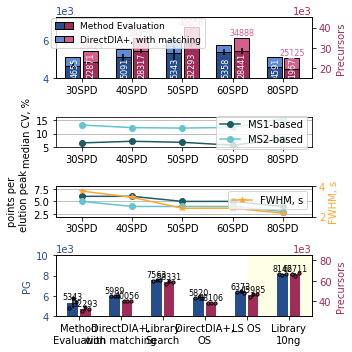

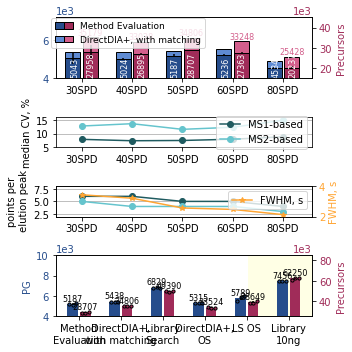

In [39]:
cols = ['JB_HeLa250pg_240k_20Th_40ms_30SPD_MBR',
   'JB_HeLa250pg_240k_20Th_40ms_30SPD_noMBR',
   'JB_HeLa250pg_240k_20Th_40ms_40SPD_MBR',
   'JB_HeLa250pg_240k_20Th_40ms_40SPD_noMBR',
   'JB_HeLa250pg_240k_20Th_40ms_50SPD_noMBR',
   'JB_HeLa250pg_240k_20Th_40ms_50SPD_MBR',
   'JB_HeLa250pg_240k_20Th_40ms_60SPD_MBR',
   'JB_HeLa250pg_240k_20Th_40ms_60SPD_noMBR',
   'JB_HeLa250pg_240k_20Th_40ms_80SPD_MBR',
   'JB_HeLa250pg_240k_20Th_40ms_80SPD_noMBR',
   'JB_HeLa250pg_240k_20Th_40ms_50SPD_L10ng',
   ]
# title= "HeLa_250pg"
data_hela = data_all.loc[cols,:] 


cols = ['MM_Astral_paper_K562_30SPD_noMBR', 'MM_Astral_paper_K562_40SPD_noMBR',
       'MM_Astral_paper_K562_50SPD_noMBR', 'MM_Astral_paper_K562_60SPD_noMBR',
       'MM_Astral_paper_K562_80SPD_noMBR', 'MM_Astral_paper_K562_30SPD_MBR',
       'MM_Astral_paper_K562_40SPD_MBR', 'MM_Astral_paper_K562_50SPD_MBR',
       'MM_Astral_paper_K562_60SPD_MBR', 'MM_Astral_paper_K562_80SPD_MBR']

data_k562 = data_all.loc[cols,:]

cols_k562_analysis = [
       'MM_Astral_paper_K562_50SPD_noMBR',
       'MM_Astral_paper_K562_50SPD_MBR',
       'MM_Astral_paper_K562_50SPD_library_search',
        "JB_250pgK562_50SPD_MBR_OS",
        "JB_250pgK562_50SPD_L10ng_OS",
'MM_Astral_paper_K562_10ng_50SPD']

cols_hela_analysis = [
       'JB_HeLa250pg_240k_20Th_40ms_50SPD_noMBR',
       'JB_HeLa250pg_240k_20Th_40ms_50SPD_MBR',
       'JB_HeLa250pg_240k_20Th_40ms_50SPD_L10ng',
        "JB_250pgHeLa_50SPD_SO_MBR",
        "JB_250pgHeLa_libraryOS",
        "JB_HeLa10ng_240k_5Th_10ms_50SPD_MBR",
        
    ]

w = 0.35
bar_w = 0.3
fig, (ax1, ax3, ax4, ax6) = plt.subplots(4, 1 , figsize=(5 , 5),  height_ratios = [6, 3, 3, 6])
plot_fig1_hela_ids(ax1, data_hela)
plot_fig1_hela_cvs(ax3, data_hela)
plot_fig1_hela_dppp(ax4, data_hela)
plot_fig1_hela_analysis(ax6, data_all, cols_hela_analysis)

fig, (ax1, ax3, ax4, ax6) = plt.subplots(4, 1 , figsize=(5 , 5),  height_ratios = [6, 3, 3, 6])
plot_fig1_hela_ids(ax1, data_k562)
plot_fig1_hela_cvs(ax3, data_k562)
plot_fig1_hela_dppp(ax4, data_k562)
plot_fig1_hela_analysis(ax6, data_all, cols_k562_analysis)

7936.333333333333 146.66666666666666
5323.0 96.66666666666667
8081.333333333333 219.77295328115
5279.333333333333 119.82301974105252


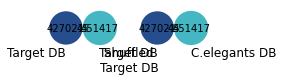

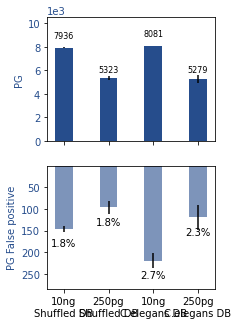

In [42]:
colors = ["#264d8c", "#44b7c2", "#a02c59", "#70b7c2", "#ffae49", "#625a65", "#aac1e8"]
labels1 = ["Target DB", " Shuffled\nTarget DB"]
labels2 = ["Target DB", "C.elegants DB"]


with open("./serialized_data/fig1/f1_panelij_target_pep.txt", "r") as f:
    target_fasta_peptides = f.read().split("\n")
with open("./serialized_data/fig1/f1_paneli_shuffled_pep.txt", "r") as f:
    decoy_fasta_peptides = f.read().split("\n")
with open("./serialized_data/fig1/f1_panelj_celegants_pep.txt", "r") as f:
    celegants_peptides = f.read().split("\n")

data = pd.read_parquet("./serialized_data/fig1/f1_panelk.parquet")
fig, (ax1, ax2,) = plt.subplots(1, 2 , figsize=(3 , 5), )
plot_fig1_fastas_intersec1(ax1, target_fasta_peptides, decoy_fasta_peptides, labels1, colors=colors)
plot_fig1_fastas_intersec1(ax2, target_fasta_peptides, celegants_peptides, labels2, colors=colors)

fig, (ax1, ax2,) = plt.subplots(2, 1 , figsize=(3 , 5), )
plot_fig1_FP1(ax1, data)
plot_fig1_FP2(ax2, data)